# Sketch of patient-specific EU classifier

In [9]:
import numpy as np
# import sys
import pandas as pd
import os
import pickle
# import scipy.io as sio
import ieeg_funcs as ief
# import re
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [180]:
np.multiply?

In [176]:
bro=np.arange(4)
print(bro)
sis=bro[bro>2]*(-1)
print(sis)

[0 1 2 3]
[-3]


In [ ]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

In [ ]:
# Define sub & feature
sub='1096'
ftr_name='EU_MAG_LAG0'

In [3]:
# Get key directories
dir_dict=ief.get_path_dict()
print(dir_dict.keys())
ftrs_root=dir_dict['ftrs_root']
print(ftrs_root)
meta_dir=dir_dict['eu_meta']

dict_keys(['onset_csv', 'pics', 'ftrs_root', 'ieeg_root', 'eu_root', 'eu_meta', 'szr_ant_root'])
/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS


In [107]:
# Load normalization parameters
ftr_path=os.path.join(ftrs_root,ftr_name,sub)
nrm_fname=os.path.join(ftr_path,'ftr_nrms.npz')
print('Loading mns and sd for feature normalization from %s' % nrm_fname)
# /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/EU_MAG_LAG0/1096/ftr_nrms.npz
ftr_nrm_dict=np.load(nrm_fname)

Loading mns and sd for feature normalization from /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/EU_MAG_LAG0/1096/ftr_nrms.npz


In [108]:
# Get list of training and validation files
split_fname=os.path.join(meta_dir,'data_splits_FR_'+sub+'.pkl')
print('Loading %s' % split_fname)
split_dict=pickle.load(open(split_fname,'rb'))
print(split_dict.keys())
train_files=split_dict['train_files']
train_szr_files=split_dict['train_szr_files']
valid_files=split_dict['valid_files']
n_train_file=len(train_files)
n_train_szr_file=len(train_szr_files)
print('%d training files (%d contain szrs)' % (n_train_file, n_train_szr_file))
n_valid_file=len(valid_files)
print('%d validation files' % n_valid_file)

Loading /Users/davidgroppe/Dropbox/TWH_INFO/EU_METADATA/data_splits_FR_1096.pkl
dict_keys(['train_files', 'test_szr_files', 'valid_files', 'train_szr_files', 'test_files', 'valid_szr_files'])
101 training files (22 contain szrs)
21 validation files


In [128]:
# IMPORT TRAINING DATA!!!!

# Import all ictal training data
# Figure out how man ictal time points there are to preallocate memory
class_path=os.path.join(ftrs_root,'EU_SZR_CLASS',sub)
n_szr_wind=0
for szr_fname in train_szr_files:
    full_fname=os.path.join(class_path,szr_fname+'_szr_class.npz')
    class_dict=np.load(full_fname)
    n_szr_wind+=np.sum(class_dict['szr_class'])
    
print('%d total szr time windows' % n_szr_wind)

# Load first feature file to determine feature dimensionality
ext_fname=os.path.join(ftr_path,'ext.txt') # Read the file extension for this type of feature
f=open(ext_fname,'r')
ext=f.readline().strip()
full_fname=os.path.join(ftr_path,train_szr_files[0]+ext)
ftr_dict=np.load(full_fname)
n_ftr_dim=ftr_dict['ftrs'].shape[0]
print('Ftr dimensionality is %d' % n_ftr_dim)

# Load ictal data
train_ftrs=np.zeros((n_ftr_dim,n_szr_wind*2)) #preallocate memory
train_class=np.ones(n_szr_wind*2,dtype='int8')
train_class[n_szr_wind:]=0
wind_ct=0
for szr_fname in train_szr_files:
    full_fname=os.path.join(ftr_path,szr_fname+ext)
    ftr_dict=np.load(full_fname)
    
    full_fname=os.path.join(class_path,szr_fname+'_szr_class.npz')
    class_dict=np.load(full_fname)
 
    temp_n_ictal_wind=np.sum(class_dict['szr_class'])
    train_ftrs[:,wind_ct:wind_ct+temp_n_ictal_wind]=ftr_dict['ftrs'][:,class_dict['szr_class']>0]
    wind_ct+=temp_n_ictal_wind

# Count # of non-ictal windows
n_nonszr_wind=0
for szr_fname in train_files:    
    full_fname=os.path.join(class_path,szr_fname+'_szr_class.npz')
    class_dict=np.load(full_fname)
    n_nonszr_wind+=np.sum(class_dict['szr_class']==0)

print('%d total NON-szr time windows' % n_nonszr_wind)

# Import an equal # of non-ictal trainin data, randomly sampled
pptn_per_file=n_szr_wind/n_nonszr_wind
print('Loading %f fraction of NON-ictal windows from each file' % pptn_per_file)
# wind_ct=0
# TODO permute the order that we see data
for fname_ct, szr_fname in enumerate(train_files):
    full_fname=os.path.join(ftr_path,szr_fname+ext)
    ftr_dict=np.load(full_fname)
    
    full_fname=os.path.join(class_path,szr_fname+'_szr_class.npz')
    class_dict=np.load(full_fname)
    
    nonszr_ids=np.where(class_dict['szr_class']==0)[0]
    temp_n_nonictal_wind=len(nonszr_ids)
    n_load_wind=int(np.round(temp_n_nonictal_wind*pptn_per_file))
    if fname_ct==(n_train_file-1):
        # If this is the last file, load exactly enough windows to equal the # 
        # of szr windows
        n_load_wind=n_szr_wind*2-wind_ct
    rand_wind_ids=nonszr_ids[np.random.randint(0,temp_n_nonictal_wind,n_load_wind)]
    train_ftrs[:,wind_ct:wind_ct+n_load_wind]=ftr_dict['ftrs'][:,rand_wind_ids]
    wind_ct+=n_load_wind

print('Done loading features!')

11726 total szr time windows
Ftr dimensionality is 48
3522050 total NON-szr time windows
Loading 0.003329 fraction of NON-ictal windows from each file
Done loading features!


In [129]:
# Normalize ftrs
for ftr_loop in range(n_ftr_dim):
    train_ftrs[ftr_loop,:]=(train_ftrs[ftr_loop,:]-
                               ftr_nrm_dict['nrm_mn'][ftr_loop])/ftr_nrm_dict['nrm_sd'][ftr_loop]

In [168]:
# Train classifier
from sklearn import linear_model
model = linear_model.LogisticRegression(C=1)
model.fit(train_ftrs.T, train_class)

# Accuracy on training data
train_class_hat = model.predict(train_ftrs.T)
train_acc=np.mean(training_class_hat==train_class)
print('Training data accuracy %f' % train_acc)

Training data accuracy 0.854767


In [ ]:
# Clear training data TODO


In [146]:
# IMPORT VALIDATION DATA!!!!

# Figure out how many validation time points there are to preallocate memory
n_valid_wind=0
for ieeg_fname in valid_files:
    full_fname=os.path.join(class_path,ieeg_fname+'_szr_class.npz')
    class_dict=np.load(full_fname)
    n_valid_wind+=len(class_dict['szr_class'])
    
print('%d total validation time windows' % n_valid_wind)

# Load ictal data
valid_ftrs=np.zeros((n_ftr_dim,n_valid_wind)) #preallocate memory
valid_class=np.ones(n_valid_wind,dtype='int8')
wind_ct=0
for szr_fname in valid_files:
    full_fname=os.path.join(ftr_path,szr_fname+ext)
    ftr_dict=np.load(full_fname)
    
    full_fname=os.path.join(class_path,szr_fname+'_szr_class.npz')
    class_dict=np.load(full_fname)
 
    temp_n_ictal_wind=len(class_dict['szr_class'])
    valid_ftrs[:,wind_ct:wind_ct+temp_n_ictal_wind]=ftr_dict['ftrs']
    valid_class[wind_ct:wind_ct+temp_n_ictal_wind]=class_dict['szr_class']
    wind_ct+=temp_n_ictal_wind

# Normalize validation data ftrs
for ftr_loop in range(n_ftr_dim):
    valid_ftrs[ftr_loop,:]=(valid_ftrs[ftr_loop,:]-
                               ftr_nrm_dict['nrm_mn'][ftr_loop])/ftr_nrm_dict['nrm_sd'][ftr_loop]
    
print('Done loading validation data!')

736467 total validation time windows
Done loading validation data!


In [169]:
# Apply classifier to validation data
valid_class_hat = model.predict(valid_ftrs.T)
jive=valid_class_hat==valid_class
valid_sens=np.sum(jive[valid_class==1])/np.sum(valid_class==1)
print('Sensitivity %f' % valid_sens)
valid_spec=np.sum(jive[valid_class==0])/np.sum(valid_class==0)
print('Specificity %f' % valid_spec)
valid_bal_acc=(valid_sens+valid_spec)/2
print('Balanced Accuracy=%f' % valid_bal_acc)
# train_acc=np.mean(training_class_hat==train_class)
# print('Training data accuracy %f' % train_acc)

Sensitivity 0.863356
Specificity 0.491922
Balanced Accuracy=0.677639


In [152]:
model.predict

In [150]:
np.mean(valid_class_hat)

0.50940911133832201

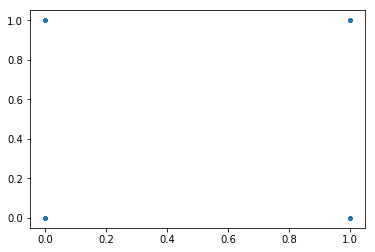

In [151]:
plt.figure(3)
plt.clf()
plt.plot(valid_class_hat,valid_class,'.');

In [ ]:
# Apply classifier to validation data

In [ ]:
# Measure validation error (all data or a random subset?)

In [ ]:
# Randomly create new inter-ictal training set by randomly sampling from training
# data based on classification performaanc